In [1]:
import tensorflow as tf
import pymongo as pymongo
import base64
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Read only mongodb connection
MONGO_URL = 'mongodb://idenmon.zapto.org:888/'
client = pymongo.MongoClient(MONGO_URL)

In [3]:
db = client.prodLaboratorio

In [4]:
cursor_img = db.markerTotals.find({'QR': '601170500100376','count': 0, 'marker': 'RV1681'})
if(cursor_img): 
    print("Records found: " + str(cursor_img.count()))
    
else: 
    print("No records!")

Records found: 1


In [5]:
def readb64(base64_string):
    nparr = np.fromstring(base64.b64decode(base64_string), np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    return img

images = []
results = []
for c in cursor_img:
    images.append(readb64(c['image']))
    results.append(c['diagnostic'])

P


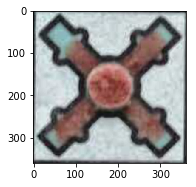

In [6]:
for i,cvimg in enumerate(images): 
    cvimgRGB = cv2.cvtColor(cvimg,cv2.COLOR_BGR2RGB)
    print(results[i])
    plt.subplot(121),plt.imshow(cvimgRGB)
    plt.show()

In [7]:
def load_graph(frozen_graph_filename):
    #Load file from disk and parse it to retrieve the unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    
    # Then, we import the graph_def into a new Graph and returns it 
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name="prefix")
    return graph

In [8]:
graph = load_graph('../data/opt_unimaHealth.pb')

# We can verify that we can access the list of operations in the graph
#for op in graph.get_operations():
    #print(op.name)

# We access the input and output nodes 
x = graph.get_tensor_by_name('prefix/x:0')
y = graph.get_tensor_by_name('prefix/y_pred:0')
pkeep = graph.get_tensor_by_name('prefix/pkeep:0')

#Format input image and set parameters values
imgSize = 90
num_channels = 3
img = cv2.resize(images[0],(imgSize, imgSize),interpolation = cv2.INTER_LINEAR)
images = []
pkeepConst = 1
#---
images.append(img)
images = np.array(images, dtype=np.uint8)
images = images.astype('float32')
images = np.multiply(images, 1.0/255.0) 
x_batch = images.reshape(1, imgSize,imgSize,num_channels)
    
# We launch a Session
with tf.Session(graph=graph) as sess:
    
    feed_dict_testing = {x: x_batch, pkeep:pkeepConst}
    result=sess.run(y, feed_dict=feed_dict_testing)
    print(result)
    if (result.item(0) > 0.75):
        print('P')
    if (result.item(1) > 0.75):
        print('N')

[[ 0.87974006  0.12025993]]
P
